# 2D EM simulation lognormal after getting a good estimate

Don't actually look at anything in this notebook

In [1]:
import pandas as pd
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats
import time
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

### Functions and constants

In [2]:
MAX_LATENT = 60
p= 0.1

In [3]:
binom_table = np.zeros(shape=(MAX_LATENT, MAX_LATENT))
    
for x in range(MAX_LATENT):
    for z in range(x, MAX_LATENT):
        binom_table[x, z] = stats.binom.pmf(x, z, p)

In [4]:
d1_binom_probs = np.tile(binom_table, MAX_LATENT)
d2_binom_probs = np.repeat(binom_table, MAX_LATENT, axis=1)

In [5]:
z_candidates_2d = np.array(list(itertools.product(np.arange(0, MAX_LATENT), np.arange(0, MAX_LATENT))))

In [6]:
z_candidates_2d.shape

(3600, 2)

In [8]:
def _fit_lognormal(x, w=None):
    
    lnx = np.log(x[x > 0])
    muhat = np.average(lnx, weights=w[x > 0])
    varhat = np.average((lnx - muhat)**2, weights=w[x > 0])
    
    return muhat, np.sqrt(varhat)

def _fit_covariance(x, mu_1, mu_2, w=None):
    """ x is a N x 2 array. """
    
    lnx = np.log(x[ (x>0).sum(axis=1) > 1 , :])
    return np.average((lnx[:, 0] - mu_1) * (lnx[:, 1] - mu_2), weights=w[(x>0).sum(axis=1) > 1 ])

In [9]:
def _lognormal_pmf_2d(x, mean, cov):

    if type(x) == list:
        x = np.array(x).reshape(-1, 2)

    x = x.astype(np.float64)

    upper_right = x + 0.5

    lower_left = x - 0.5

    upper_left = x.copy()
    upper_left[:, 0] = upper_left[:, 0] - 0.5
    upper_left[:, 1] = upper_left[:, 1] + 0.5

    lower_right = x.copy()
    lower_right[:, 0] = lower_right[:, 0] + 0.5
    lower_right[:, 1] = lower_right[:, 1] - 0.5

    both_zero = (x.sum(axis=1) == 0)
    d0_zero = (x[:, 0] == 0) & (x[:, 1] != 0)
    d1_zero = (x[:, 1] == 0) & (x[:, 0] != 0)
    both_nonzero = ~(d0_zero | d1_zero | both_zero)

    upper_right_cdf = stats.multivariate_normal.cdf(np.log(upper_right), mean=mean, cov=cov)
    lower_left_cdf = np.nan_to_num(stats.multivariate_normal.cdf(np.log(lower_left), mean=mean, cov=cov))
    upper_left_cdf = np.nan_to_num(stats.multivariate_normal.cdf(np.log(upper_left), mean=mean, cov=cov))
    lower_right_cdf = np.nan_to_num(stats.multivariate_normal.cdf(np.log(lower_right), mean=mean, cov=cov))

    both_zeros_pmf = upper_right_cdf
    d1_zero_pmf = upper_right_cdf - upper_left_cdf
    d0_zero_pmf = upper_right_cdf - lower_right_cdf
    both_nonzero_pmf = upper_right_cdf - lower_right_cdf - (upper_left_cdf-lower_left_cdf)

    return \
        (both_zeros_pmf * both_zero) + \
        (d1_zero_pmf * d1_zero) + \
        (d0_zero_pmf * d0_zero) + \
        (both_nonzero_pmf * both_nonzero)

In [10]:
def _multivariate_pmf(x, mean, cov, method='lognormal'):
    """ Multivariate normal PMF. """

    if method == 'normal':

        return multivariate_normal.pdf(x, mean=mean, cov=cov)

    if method == 'lognormal':

        return _lognormal_pmf_2d(x, mean=mean, cov=cov)

In [10]:
def _create_px_table_2d(mu, sigma, p, method):
    
    pmf_table = np.tile(_multivariate_pmf(z_candidates_2d, mean=mu, cov=sigma, method=method), (MAX_LATENT, 1))
    
    return (d1_binom_probs * pmf_table).dot(d2_binom_probs.T).T

In [11]:
z_cand = np.tile(z_candidates_2d, (MAX_LATENT**2, 1))
x_table = np.repeat(z_candidates_2d, MAX_LATENT**2, axis=0)
d1_binom = np.repeat(np.repeat(binom_table, MAX_LATENT, axis=1), MAX_LATENT, axis=0).reshape(-1, 1)
d2_binom = np.tile(np.tile(binom_table, (1, MAX_LATENT)), (MAX_LATENT, 1)).reshape(-1, 1)


def _create_pz_table_2d_bf(mu, sigma, p, method, px_table):
    
    table = []
    for x1 in range(MAX_LATENT):
        for x2 in range(MAX_LATENT):
            for z1 in range(MAX_LATENT):
                for z2 in range(MAX_LATENT):
                    table.append((
                        x1, x2, z1, z2,
                        _multivariate_pmf([z1, z2], mean=mu, cov=sigma, method=method)[0] * \
                        binom_table[x1, z1] * \
                        binom_table[x2, z2] / \
                        px_table[x1, x2]))
    return pd.DataFrame(table, columns=['x1', 'x2', 'z1', 'z2', 'latent_weight'])


def _create_pz_table_2d(mu, sigma, p, method, px_table):
    """ Returns a matrix M x M where rows indicate X and columns indicate Z """

    x_prob = np.repeat(px_table.reshape(-1, 1), MAX_LATENT**2, axis=0)
    z_prob = np.tile(_multivariate_pmf(z_candidates_2d, mean=mu, cov=sigma, method=method), (1, MAX_LATENT**2)).reshape(-1, 1)
    
    table = np.hstack([x_table, z_cand, z_prob*d1_binom*d2_binom/x_prob])
    return pd.DataFrame(table, columns=['x1', 'x2', 'z1', 'z2', 'latent_weight'])

In [12]:
def _fit_multivariate_distribution(data, d1_col='z1', d2_col='z2', weights_col='point_weight', method='lognormal'):

    if method == 'normal':

        parameters = DescrStatsW(data[[d1_col, d2_col]], weights=data[weights_col])

    elif method == 'lognormal':

        ln_data = data.query('{} > 0 & {} > 0'.format(d1_col, d2_col))

        mu_1, std_1 = _fit_lognormal(ln_data[d1_col], ln_data[weights_col])
        mu_2, std_2 = _fit_lognormal(ln_data[d2_col], ln_data[weights_col])

        print(ln_data[weights_col].sum())
        cov = np.average((ln_data[d1_col] - mu_1) * (ln_data[d2_col] - mu_2), weights=ln_data[weights_col])

    return np.array([mu_1, mu_2]), np.array([[std_1**2, cov], [cov, std_2**2]])

### Simulate some data

In [208]:
mu = np.array([1, 0.2])
cov = np.array([[1.2**2, 0.3],[0.3, 0.6**2]])
p=0.05
num_cells = 100000

In [209]:
mvn = np.random.multivariate_normal(mu, cov, size=num_cells)
ground_truth_counts = np.round(np.exp(mvn))
observed = np.random.binomial(n=ground_truth_counts.astype(int), p=p)

In [210]:
observed = np.random.binomial(n=ground_truth_counts.astype(int), p=p)

In [211]:
np.log(np.cov(observed.T)[0, 1]/(p**2 * np.exp(mu.sum() + (cov[0, 0] + cov[1, 1])/2)) + 1)

0.298379975692647

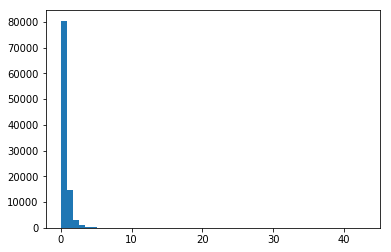

In [171]:
plt.hist(observed[:, 0], bins=50);